# Machine Learning Models for Classification

In [29]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the Excel file
file_path = 'DATA/OSA_DB_class.xlsx'
df = pd.read_excel(file_path)

df_class = df.drop(columns=[ 'Weight', 'Height'])

# Convert Gender into categorical
df_class['Gender'] = df_class['Gender'].astype('category')

print(df_class.dtypes)

df_class.head()


Gender      category
Age          float64
Cervical     float64
BMI          float64
OSA           object
dtype: object


,Gender,Age,Cervical,BMI,OSA
0,1,39.0,40.617735,29.053288,Severe
1,1,46.0,43.000000,29.885548,Severe
2,1,32.0,42.000000,30.193906,Healthy
3,1,39.0,42.000000,30.110991,Severe
4,1,47.0,44.000000,49.012980,Severe


[0]
Original dataset shape: Severe     134
Healthy    106
Name: OSA, dtype: int64
Resampled dataset shape: Severe     134
Healthy    134
Name: OSA, dtype: int64


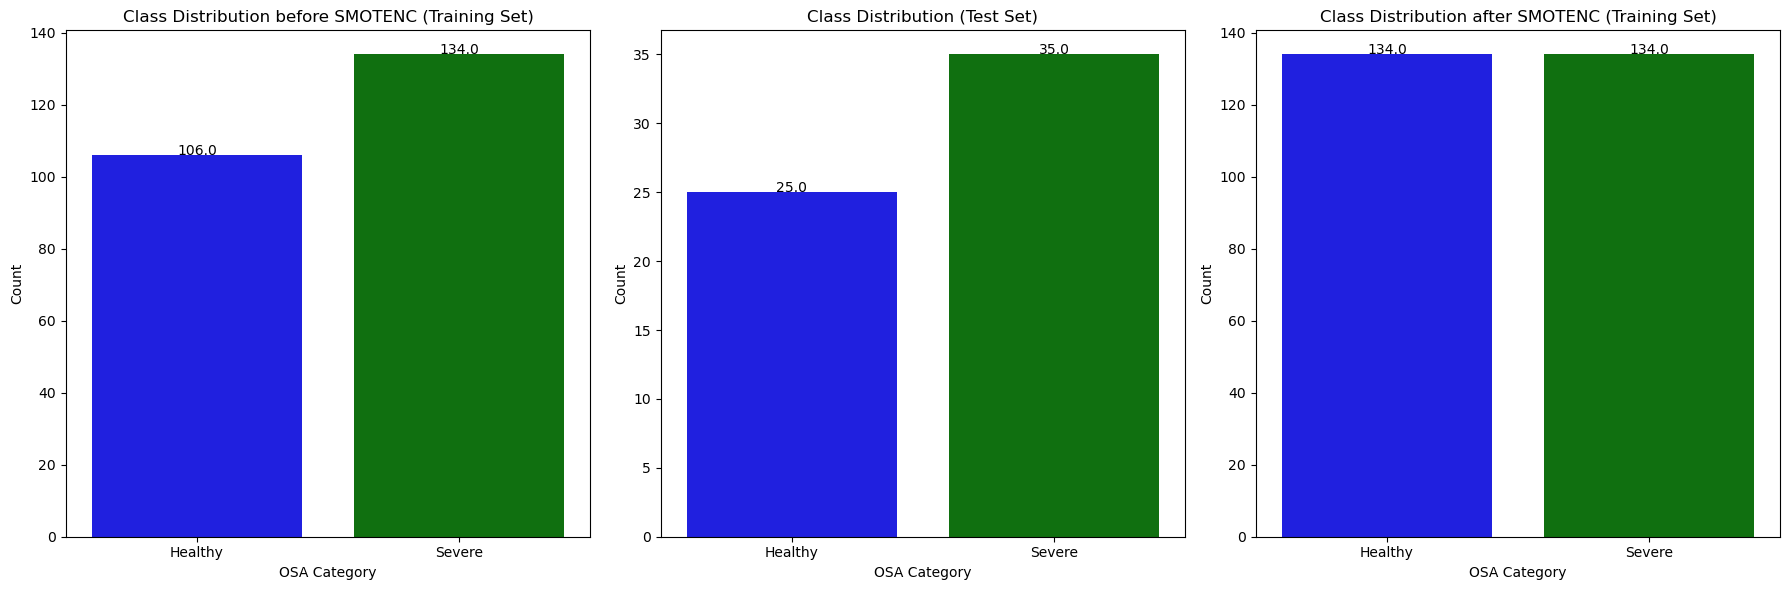

In [30]:
from imblearn.over_sampling import SMOTENC
from sklearn.model_selection import train_test_split

# Assuming 'df' is your DataFrame and 'OSA' is the target variable
X = df_class.drop(columns=['OSA'])
y = df_class['OSA']

# Identify the indices of categorical features
categorical_features = [X.columns.get_loc(col) for col in X.select_dtypes(include=['object', 'category']).columns]
print(categorical_features)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTENC
smote_nc = SMOTENC(categorical_features=categorical_features, random_state=42)
X_train_resampled, y_train_resampled = smote_nc.fit_resample(X_train, y_train)

# Verify the resampling
print(f'Original dataset shape: {y_train.value_counts()}')
print(f'Resampled dataset shape: {y_train_resampled.value_counts()}')



# Plot the data distribution before resampling
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

sns.countplot(ax=axes[0], x=y_train, order=['Healthy', 'Severe'], palette={'Healthy': 'blue', 'Severe': 'green'})
axes[0].set_title('Class Distribution before SMOTENC (Training Set)')
axes[0].set_xlabel('OSA Category')
axes[0].set_ylabel('Count')

# Annotate the bars with the absolute values
for p in axes[0].patches:
    axes[0].annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='baseline')

sns.countplot(ax=axes[1], x=y_test, order=['Healthy', 'Severe'], palette={'Healthy': 'blue', 'Severe': 'green'})
axes[1].set_title('Class Distribution (Test Set)')
axes[1].set_xlabel('OSA Category')
axes[1].set_ylabel('Count')
# Annotate the bars with the absolute values
for p in axes[1].patches:
    axes[1].annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='baseline')

sns.countplot(ax=axes[2], x=y_train_resampled, order=['Healthy', 'Severe'], palette={'Healthy': 'blue', 'Severe': 'green'})
axes[2].set_title('Class Distribution after SMOTENC (Training Set)')
axes[2].set_xlabel('OSA Category')
axes[2].set_ylabel('Count')
# Annotate the bars with the absolute values
for p in axes[2].patches:
    axes[2].annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='baseline')

plt.tight_layout()
plt.show()


In [31]:
# Perform mapping
y_train_mapped = y_train.map({'Healthy': 0, 'Severe': 1})
y_train_resampled_mapped = y_train_resampled.map({'Healthy': 0, 'Severe': 1})
y = y.map({'Healthy': 0, 'Severe': 1})

# Verify the mapping
print(y_train_mapped.head())
print(y_train_resampled_mapped.head())

232    1
59     1
6      0
185    1
173    1
Name: OSA, dtype: int64
0    1
1    1
2    0
3    1
4    1
Name: OSA, dtype: int64


## To get started: get more intuition in the concept of nested cross-validation

## Test 1
Based on source: Ploomber. (2022, April 11). Model selection done right: A gentle introduction to nested cross-validation. https://ploomber.io/blog/nested-cv/

### Wrong: when using data seen in training for testing
This leads to overly optimistic results of the model's performance

In [32]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

clf = RandomForestClassifier(n_estimators=2, random_state=0)
# X is our training data
clf.fit(X, y)

# This is an overly optimistic estimation since we are using X again!
y_pred = clf.predict(X)
acc = accuracy_score(y, y_pred)

print(f'Accuracy: {acc:.2f}')

Accuracy: 0.91


### Improvement: split in train and test set 
problem: performance is still sensible to the selection of the test set

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# split in train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

clf = RandomForestClassifier(n_estimators=2, random_state=0)
clf.fit(X_train, y_train)

# test with unseen data
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print(f'Accuracy: {acc:.2f}')

Accuracy: 0.67


### Improvement: perform Cross-validation to estimate the performance of the model
Good for estimating the generalization error with cross-validation 

In [34]:
from sklearn.model_selection import cross_validate

def do_cross_validation(clf, print_model=False):
    cv = cross_validate(clf, X, y, scoring='accuracy', cv=5) # splits data into train+validation and test
    scores = ' + '.join(f'{s:.2f}' for s in cv["test_score"])
    mean_ = cv["test_score"].mean()
    msg = f'Cross-validated accuracy: ({scores}) / 3 = {mean_:.2f}'
    
    if print_model:
        msg = f'{clf}:\n\t{msg}\n'
    
    print(msg)

do_cross_validation(clf)

Cross-validated accuracy: (0.70 + 0.60 + 0.65 + 0.70 + 0.68) / 3 = 0.67


In [35]:
from sklearn.svm import SVC

svc = SVC(random_state=0)
do_cross_validation(svc)

Cross-validated accuracy: (0.73 + 0.77 + 0.80 + 0.85 + 0.85) / 3 = 0.80


### Problem: we use the (vanilla) cross-validation method to optimize hyperparameters and model selection
This can lead to an overly optimistic generalization error (due to overfitting) 



In [36]:
do_cross_validation(SVC(kernel='linear', random_state=0), print_model=True)
do_cross_validation(SVC(kernel='poly', random_state=0), print_model=True)
do_cross_validation(RandomForestClassifier(n_estimators=2, random_state=0), print_model=True)
do_cross_validation(RandomForestClassifier(n_estimators=5, random_state=0), print_model=True)

SVC(kernel='linear', random_state=0):
	Cross-validated accuracy: (0.75 + 0.70 + 0.80 + 0.83 + 0.83) / 3 = 0.78

SVC(kernel='poly', random_state=0):
	Cross-validated accuracy: (0.77 + 0.68 + 0.80 + 0.85 + 0.78) / 3 = 0.78

RandomForestClassifier(n_estimators=2, random_state=0):
	Cross-validated accuracy: (0.70 + 0.60 + 0.65 + 0.70 + 0.68) / 3 = 0.67

RandomForestClassifier(n_estimators=5, random_state=0):
	Cross-validated accuracy: (0.78 + 0.68 + 0.77 + 0.83 + 0.73) / 3 = 0.76



### Improvement: Nested Cross-validation

In [37]:
from sklearn.model_selection import GridSearchCV

# random forest inner loop
clf_grid = GridSearchCV(RandomForestClassifier(random_state=0), param_grid={'n_estimators': [2, 5]})

# random forest outer loop
do_cross_validation(clf_grid, print_model=True)

# svc inner loop
svc_grid = GridSearchCV(SVC(random_state=0), param_grid={'kernel': ['linear', 'poly']})

# svc outer loop
do_cross_validation(svc_grid, print_model=True)

GridSearchCV(estimator=RandomForestClassifier(random_state=0),
             param_grid={'n_estimators': [2, 5]}):
	Cross-validated accuracy: (0.78 + 0.68 + 0.77 + 0.83 + 0.73) / 3 = 0.76

GridSearchCV(estimator=SVC(random_state=0),
             param_grid={'kernel': ['linear', 'poly']}):
	Cross-validated accuracy: (0.77 + 0.68 + 0.80 + 0.83 + 0.78) / 3 = 0.77



## Test 2
Based on source: Nested versus non-nested cross-validation. (n.d.). Scikit-learn. https://scikit-learn.org/1.5/auto_examples/model_selection/plot_nested_cross_validation_iris.html

Average difference of 0.009333 with std. dev. of 0.011069.


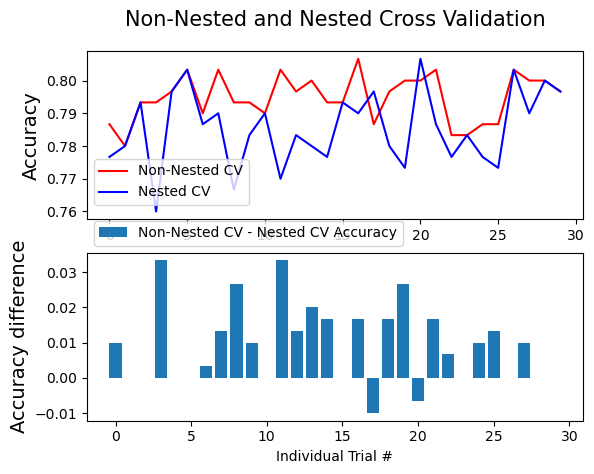

In [38]:
import numpy as np
from matplotlib import pyplot as plt

from sklearn.datasets import load_iris
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn.svm import SVC

# Number of random trials
NUM_TRIALS = 30

# Set up possible values of parameters to optimize over
p_grid = {"C": [1, 10, 100], "gamma": [0.01, 0.1]}

# We will use a Support Vector Classifier with "rbf" kernel
svm = SVC(kernel="rbf")

# Arrays to store scores
non_nested_scores = np.zeros(NUM_TRIALS)
nested_scores = np.zeros(NUM_TRIALS)

# Loop for each trial
for i in range(NUM_TRIALS):
    # Choose cross-validation techniques for the inner and outer loops,
    # independently of the dataset.
    # E.g "GroupKFold", "LeaveOneOut", "LeaveOneGroupOut", etc.
    inner_cv = KFold(n_splits=4, shuffle=True, random_state=i) # splits the train+validation into train and validation
    outer_cv = KFold(n_splits=4, shuffle=True, random_state=i) # splits the data into train+validation and test

    # Non_nested parameter search and scoring
    clf = GridSearchCV(estimator=svm, scoring= 'accuracy', param_grid=p_grid, cv=outer_cv)
    clf.fit(X, y)
    non_nested_scores[i] = clf.best_score_

    # Nested CV with parameter optimization
    clf = GridSearchCV(estimator=svm, scoring= 'accuracy', param_grid=p_grid, cv=inner_cv) # inner loop for hyperparameter optimization
    nested_score = cross_val_score(clf, X=X, y=y, cv=outer_cv) # outer loop for model selection 
    nested_scores[i] = nested_score.mean()

score_difference = non_nested_scores - nested_scores

print(
    "Average difference of {:6f} with std. dev. of {:6f}.".format(
        score_difference.mean(), score_difference.std()
    )
)

# Plot scores on each trial for nested and non-nested CV
plt.figure()
plt.subplot(211)
(non_nested_scores_line,) = plt.plot(non_nested_scores, color="r")
(nested_line,) = plt.plot(nested_scores, color="b")
plt.ylabel("Accuracy", fontsize="14")
plt.legend(
    [non_nested_scores_line, nested_line],
    ["Non-Nested CV", "Nested CV"],
    bbox_to_anchor=(0, 0.4, 0.5, 0),
)
plt.title(
    "Non-Nested and Nested Cross Validation",
    x=0.5,
    y=1.1,
    fontsize="15",
)

# Plot bar chart of the difference.
plt.subplot(212)
difference_plot = plt.bar(range(NUM_TRIALS), score_difference)
plt.xlabel("Individual Trial #")
plt.legend(
    [difference_plot],
    ["Non-Nested CV - Nested CV Accuracy"],
    bbox_to_anchor=(0, 1, 0.8, 0),
)
plt.ylabel("Accuracy difference", fontsize="14")

plt.show()

## Test 3
Based on source: Brownlee, J. (2021, November 19). Nested Cross-Validation for Machine Learning with Python. MachineLearningMastery.com. https://machinelearningmastery.com/nested-cross-validation-for-machine-learning-with-python/

### Manual nested cross-validation for random forest on a classification dataset

In [39]:
from numpy import mean
from numpy import std
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

def Nested_CV_manual(classifier, space):
        
    # configure the cross-validation procedure
    cv_outer = KFold(n_splits=5, shuffle=True, random_state=1)

    # enumerate splits
    outer_results = list()
    for train_ix, test_ix in cv_outer.split(X):
        # split data
        X_train, X_test = X.iloc[train_ix, :], X.iloc[test_ix, :]
        y_train, y_test = y.iloc[train_ix], y.iloc[test_ix]

        # configure the cross-validation procedure
        cv_inner = KFold(n_splits=3, shuffle=True, random_state=1)

        # define the model
        model = Pipeline([
            ('scaler', MinMaxScaler()),
            ('classifier', classifier)
        ])
        
        # define the model
        model = RandomForestClassifier(random_state=1)
        
        # define search
        search = GridSearchCV(model, space, scoring='accuracy', cv=cv_inner, refit=True)
        
        # execute search
        result = search.fit(X_train, y_train)
        
        # get the best performing model fit on the whole training set
        best_model = result.best_estimator_
        
        # evaluate model on the hold out dataset
        yhat = best_model.predict(X_test)
        
        # evaluate the model
        acc = accuracy_score(y_test, yhat)
        
        # store the result
        outer_results.append(acc)
        
        # report progress
        print('>acc=%.3f, est=%.3f, cfg=%s' % (acc, result.best_score_, result.best_params_))

    # summarize the estimated performance of the model
    print('Accuracy: %.3f (%.3f)' % (mean(outer_results), std(outer_results)))

In [40]:
# define search space
space = dict()
space['n_estimators'] = [10, 100, 500]
space['max_features'] = [2, 4, 6]

Nested_CV_manual(RandomForestClassifier(random_state=1), space)


>acc=0.783, est=0.792, cfg={'max_features': 2, 'n_estimators': 500}
>acc=0.783, est=0.796, cfg={'max_features': 4, 'n_estimators': 100}
>acc=0.783, est=0.800, cfg={'max_features': 2, 'n_estimators': 100}
>acc=0.867, est=0.838, cfg={'max_features': 2, 'n_estimators': 100}
>acc=0.817, est=0.771, cfg={'max_features': 4, 'n_estimators': 100}
Accuracy: 0.807 (0.033)


### Automatic nested cross-validation for random forest on a classification dataset

In [41]:
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

def Nested_CV_automatic(classifier, space):
    # configure the cross-validation procedure
    cv_outer = KFold(n_splits=5, shuffle=True, random_state=1)
    # configure the cross-validation procedure
    cv_inner = KFold(n_splits=3, shuffle=True, random_state=1)
    # define the model
    model = Pipeline([
        ('scaler', MinMaxScaler()),
        ('classifier', classifier)
    ])
    # define search
    search = GridSearchCV(classifier, space, scoring='accuracy', n_jobs=-1, cv=cv_inner, refit=True)
    # execute the nested cross-validation
    scores = cross_val_score(search, X, y, scoring='accuracy', cv=cv_outer, n_jobs=-1)
    # report performance
    print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))
    


In [42]:
space = dict()
space['n_estimators'] = [10, 100, 500]
space['max_features'] = [2, 4, 6]

Nested_CV_automatic(RandomForestClassifier(random_state=1), space)

Accuracy: 0.807 (0.033)


# <font color=#BB44>**General function for Nested CV**</font>

In [43]:
from numpy import mean
from numpy import std
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTENC
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Identify the indices of categorical features
categorical_features = [X.columns.get_loc(col) for col in X.select_dtypes(include=['object', 'category']).columns]

# Apply SMOTENC
smote_nc = SMOTENC(categorical_features=categorical_features, random_state=42)

# Initialize the MinMaxScaler
min_max_scaler = MinMaxScaler()

def Nested_CV(classifier, space):
        
    # configure the cross-validation procedure
    cv_outer = KFold(n_splits=5, shuffle=True, random_state=42)

    # enumerate splits
    outer_results = list()
    for train_ix, test_ix in cv_outer.split(X):
        # split data
        X_train, X_test = X.iloc[train_ix, :], X.iloc[test_ix, :]
        y_train, y_test = y.iloc[train_ix], y.iloc[test_ix]

        # Fit the scaler on the training data and transform the training data
        X_train_scaled = min_max_scaler.fit_transform(X_train)

        # Transform the test data using the same scaler
        X_test_scaled = min_max_scaler.transform(X_test)

        X_train_resampled, y_train_resampled = smote_nc.fit_resample(X_train_scaled, y_train)

        # configure the cross-validation procedure
        cv_inner = KFold(n_splits=5, shuffle=True, random_state=42)
        
        # define search
        search = GridSearchCV(classifier, space, scoring='f1', cv=cv_inner, refit=True)
        
        # execute search
        result = search.fit(X_train_resampled, y_train_resampled)
        
        # get the best performing model fit on the whole training set
        best_model = result.best_estimator_
        
        # evaluate model on the hold out dataset
        yhat = best_model.predict(X_test_scaled)
        
        # evaluate the model
        acc = accuracy_score(y_test, yhat)
        auc = roc_auc_score(y_test, yhat)
        f1 = f1_score(y_test, yhat)
        precision = precision_score(y_test, yhat)
        recall = recall_score(y_test, yhat)

        # store the result
        outer_results.append({
            'accuracy': acc,
            'roc_auc': auc,
            'f1_score': f1,
            'precision': precision,
            'recall': recall, 
            'configuration': result.best_params_
        })

        # Convert the results to a pandas DataFrame
        results_df = pd.DataFrame(outer_results)

    # Display the table with all results
    display(results_df)

    # Find the dictionary with the lowest RMSE value in outer_results
    best_result = max(outer_results, key=lambda x: x['f1_score'])

    # Create a DataFrame to display the best result in a table
    best_result_df = pd.DataFrame([best_result])

    print('-------------------Best parameters based on f1-score-------------------')
    print(best_result_df['configuration'].values[0])
    display(best_result_df)

    # Predict the test set results using the best model
    best_model = result.best_estimator_
    y_pred = best_model.predict(X_test_scaled)

    # Compute the confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Display the confusion matrix using seaborn heatmap
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    # print the title based on the classifier
    plt.title(f'Confusion Matrix for {classifier.__class__.__name__}')
    plt.show()

    return best_result_df

## Multiple Logistic Regression 

In [44]:
from pprint import pprint
from sklearn.linear_model import LogisticRegression

# Define the logistic regression model with the specified parameters
log_reg = LogisticRegression(C=1, penalty='l2', solver='liblinear', random_state=42)

# Print the parameters of the logistic regression model
print('Parameters currently in use:\n')
pprint(log_reg.get_params())

Parameters currently in use:

{'C': 1,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 42,
 'solver': 'liblinear',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}


,accuracy,roc_auc,f1_score,precision,recall,configuration
0,0.716667,0.705714,0.760563,0.750000,0.771429,"{'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}"
1,0.800000,0.800000,0.823529,0.848485,0.800000,"{'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}"
2,0.800000,0.787330,0.833333,0.789474,0.882353,"{'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}"
3,0.850000,0.850168,0.861538,0.875000,0.848485,"{'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}"
4,0.833333,0.834821,0.838710,0.866667,0.812500,"{'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}"


-------------------Best parameters based on f1-score-------------------
{'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}


,accuracy,roc_auc,f1_score,precision,recall,configuration
0,0.85,0.850168,0.861538,0.875,0.848485,"{'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}"


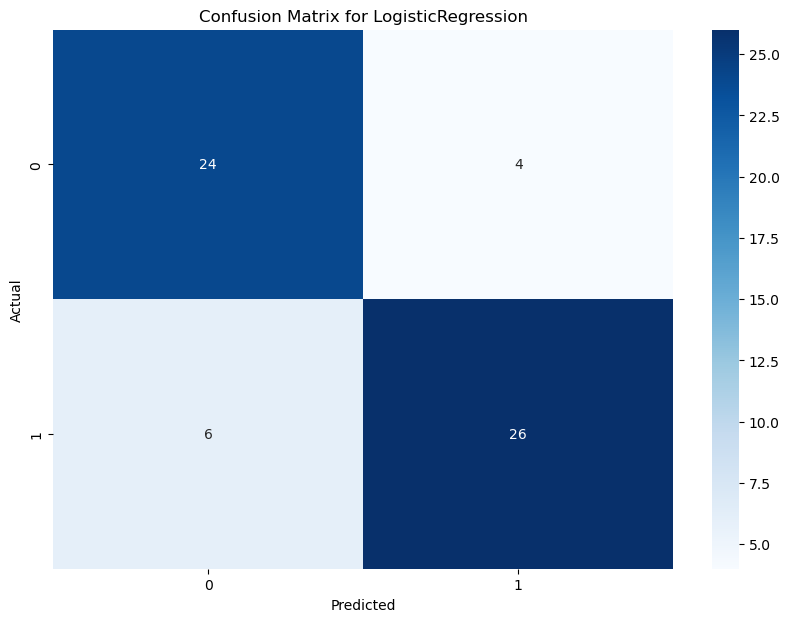

In [45]:
# Define search space for Logistic Regression
space = dict()
space['C'] = [0.1, 1, 10]
space['penalty'] = ['l1', 'l2']
space['solver'] = ['liblinear']

# Train Logistic Regression model using Nested Cross-Validation
Model_Logistic_Regression = Nested_CV(LogisticRegression(random_state=42), space)

False Positives: 16
False Negatives: 12


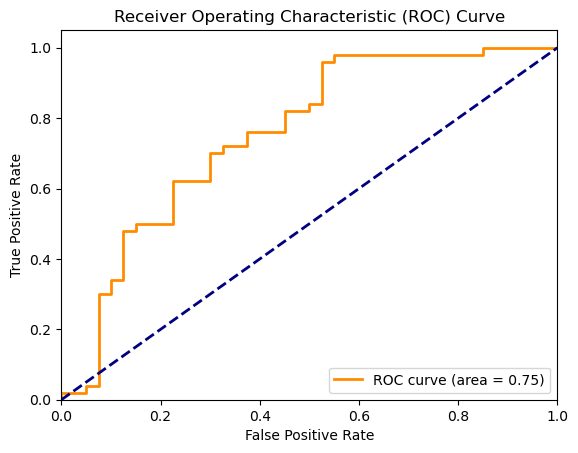

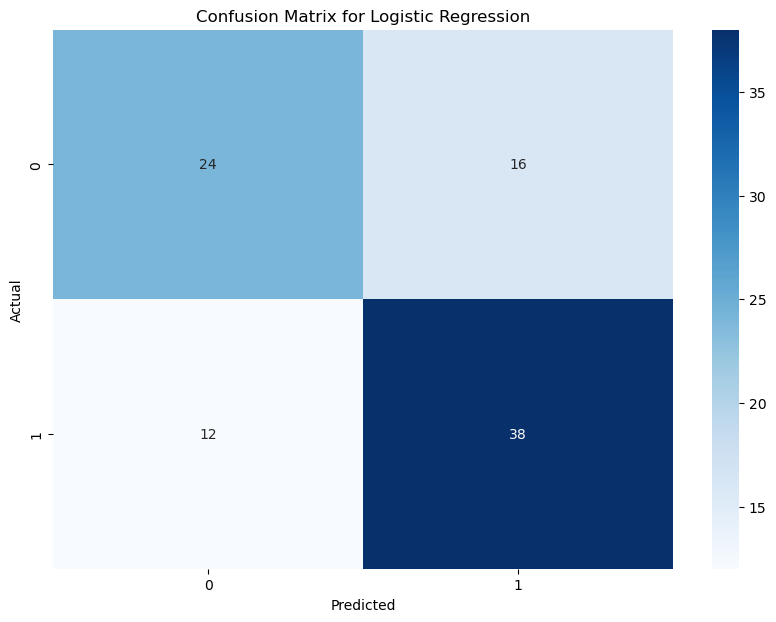

In [46]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc

import matplotlib.pyplot as plt

# Define the logistic regression model with the specified parameters
log_reg = LogisticRegression(C=1, penalty='l2', solver='liblinear', random_state=42)

# Train the model
log_reg.fit(X_train, y_train)

# Predict probabilities for the test set
y_prob = log_reg.predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

y_pred = log_reg.predict(X_test)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Extract false positives and false negatives
false_positives = cm[0, 1]
false_negatives = cm[1, 0]

print(f'False Positives: {false_positives}')
print(f'False Negatives: {false_negatives}')

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Display the confusion matrix using seaborn heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Logistic Regression')
plt.show()

c:\Users\pc\anaconda3\envs\ENV_MLLB\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


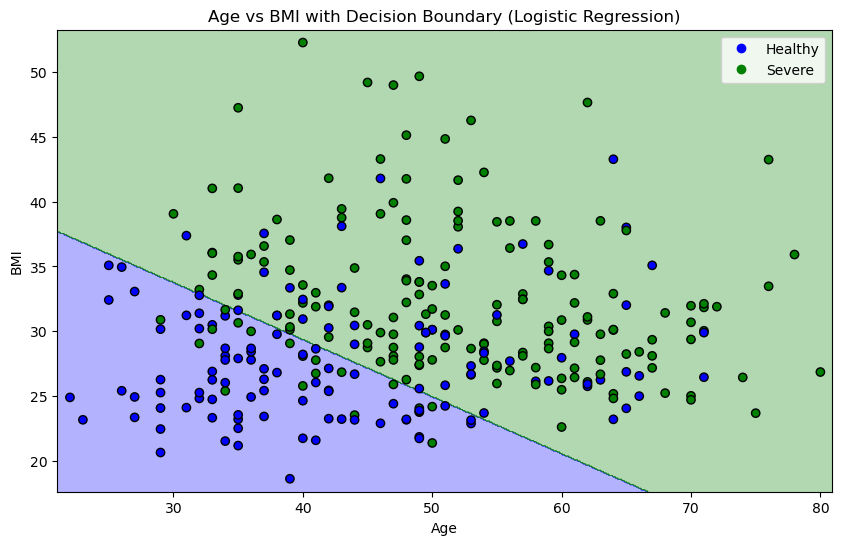

In [52]:
import numpy as np
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

# Define the logistic regression model with the specified parameters
log_reg = LogisticRegression(C=1, penalty='l2', solver='liblinear', random_state=42)

# Train the model
log_reg.fit(X_train[['Age', 'BMI']], y_train)

# Create a mesh grid for plotting decision boundary
x_min, x_max = X['Age'].min() - 1, X['Age'].max() + 1
y_min, y_max = X['BMI'].min() - 1, X['BMI'].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

# Predict the function value for the whole grid
Z = log_reg.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot the decision boundary
plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, Z, alpha=0.3, cmap=ListedColormap(['blue', 'green']))

# Plot the points
scatter = plt.scatter(X['Age'], X['BMI'], c=y, edgecolor='k', cmap=ListedColormap(['blue', 'green']))
plt.xlabel('Age')
plt.ylabel('BMI')
plt.title('Age vs BMI with Decision Boundary (Logistic Regression)')

# Add legend
handles, labels = scatter.legend_elements()
plt.legend(handles, ['Healthy', 'Severe'], loc='upper right')

plt.show()


## Support Vector Machine 

,accuracy,roc_auc,f1_score,precision,recall,configuration
0,0.716667,0.705714,0.760563,0.750000,0.771429,"{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}"
1,0.700000,0.714286,0.709677,0.814815,0.628571,"{'C': 1, 'gamma': 'scale', 'kernel': 'poly'}"
2,0.766667,0.753394,0.805556,0.763158,0.852941,"{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}"
3,0.850000,0.846801,0.865672,0.852941,0.878788,"{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}"
4,0.816667,0.819196,0.819672,0.862069,0.781250,"{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}"


-------------------Best parameters based on f1-score-------------------
{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}


,accuracy,roc_auc,f1_score,precision,recall,configuration
0,0.85,0.846801,0.865672,0.852941,0.878788,"{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}"


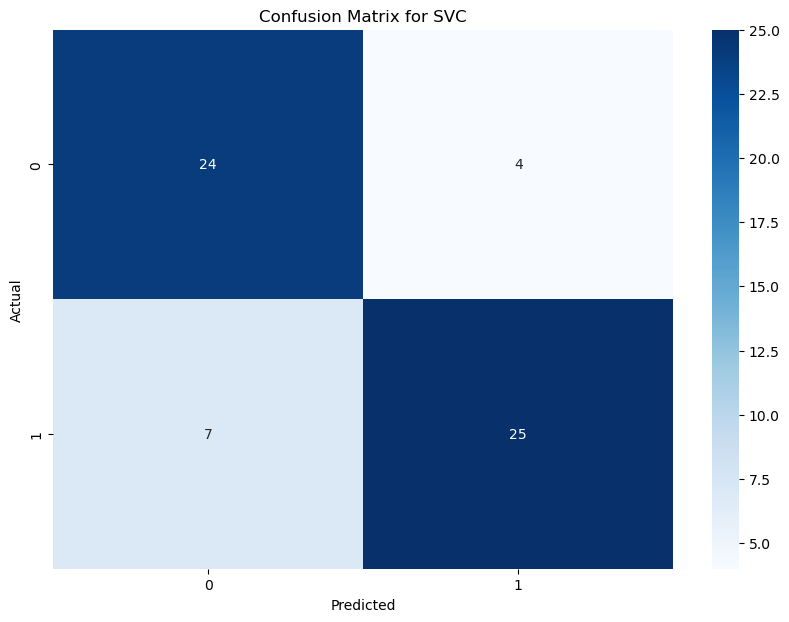

In [50]:
# Define search space for SVM
space = dict()
space['C'] = [0.1, 1, 10]
space['kernel'] = ['linear', 'poly', 'rbf']
space['gamma'] = ['scale', 'auto']

# Train SVM model using Nested Cross-Validation
Model_SVM =  Nested_CV(SVC(random_state=42), space)

c:\Users\pc\anaconda3\envs\ENV_MLLB\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


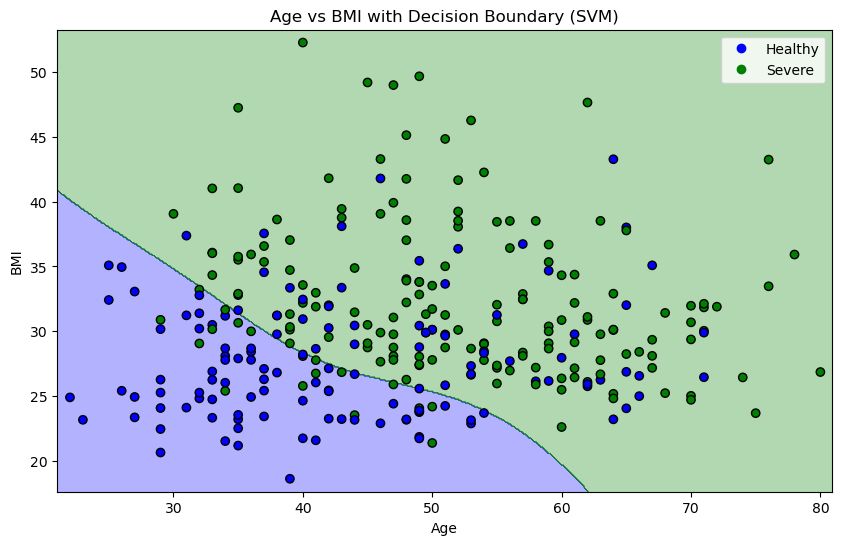

In [51]:
from sklearn.svm import SVC
import numpy as np
from matplotlib.colors import ListedColormap

import matplotlib.pyplot as plt

# Define the SVM model with the specified parameters
svm_model = SVC(C=10, kernel='rbf', gamma='scale', random_state=42)

# Train the model
svm_model.fit(X_train[['Age', 'BMI']], y_train)

# Create a mesh grid for plotting decision boundary
x_min, x_max = X['Age'].min() - 1, X['Age'].max() + 1
y_min, y_max = X['BMI'].min() - 1, X['BMI'].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

# Predict the function value for the whole grid
Z = svm_model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot the decision boundary
plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, Z, alpha=0.3, cmap=ListedColormap(['blue', 'green']))

# Plot the points
scatter = plt.scatter(X['Age'], X['BMI'], c=y, edgecolor='k', cmap=ListedColormap(['blue', 'green']))
plt.xlabel('Age')
plt.ylabel('BMI')
plt.title('Age vs BMI with Decision Boundary (SVM)')

# Add legend
handles, labels = scatter.legend_elements()
plt.legend(handles, ['Healthy', 'Severe'], loc='upper right')

plt.show()

## Decision Tree

,accuracy,roc_auc,f1_score,precision,recall,configuration
0,0.783333,0.774286,0.816901,0.805556,0.828571,"{'max_depth': 3, 'min_samples_leaf': 4, 'min_s..."
1,0.800000,0.788571,0.833333,0.810811,0.857143,"{'max_depth': 3, 'min_samples_leaf': 1, 'min_s..."
2,0.783333,0.772624,0.816901,0.783784,0.852941,"{'max_depth': 5, 'min_samples_leaf': 2, 'min_s..."
3,0.800000,0.787879,0.833333,0.769231,0.909091,"{'max_depth': 3, 'min_samples_leaf': 1, 'min_s..."
4,0.850000,0.850446,0.857143,0.870968,0.843750,"{'max_depth': 5, 'min_samples_leaf': 1, 'min_s..."


-------------------Best parameters based on f1-score-------------------
{'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}


,accuracy,roc_auc,f1_score,precision,recall,configuration
0,0.85,0.850446,0.857143,0.870968,0.84375,"{'max_depth': 5, 'min_samples_leaf': 1, 'min_s..."


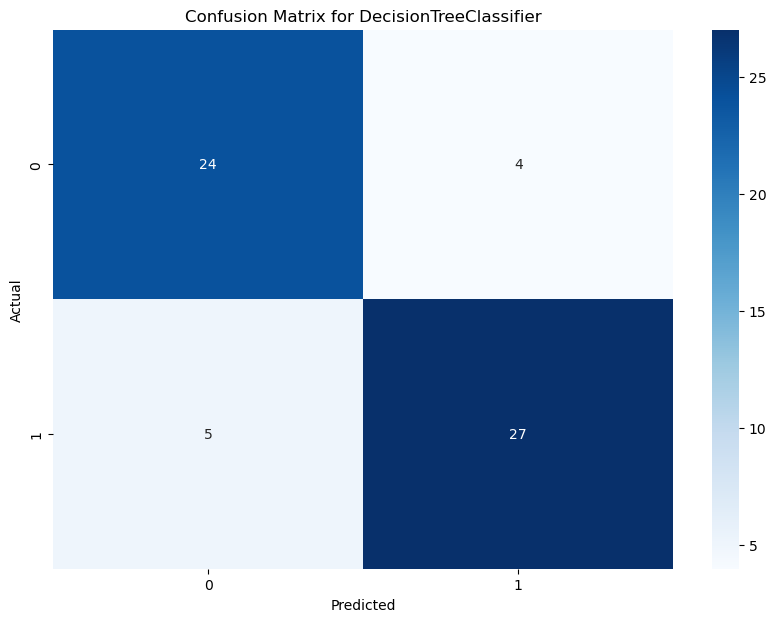

In [20]:
from sklearn.tree import DecisionTreeClassifier

# Define search space for Decision Tree
space = dict()
space['max_depth'] = [3, 5, 7, 10]
space['min_samples_split'] = [2, 5, 10]
space['min_samples_leaf'] = [1, 2, 4]

# Train Decision Tree model using Nested Cross-Validation
Model_Decision_Tree = Nested_CV(DecisionTreeClassifier(random_state=42), space)

c:\Users\pc\anaconda3\envs\ENV_MLLB\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


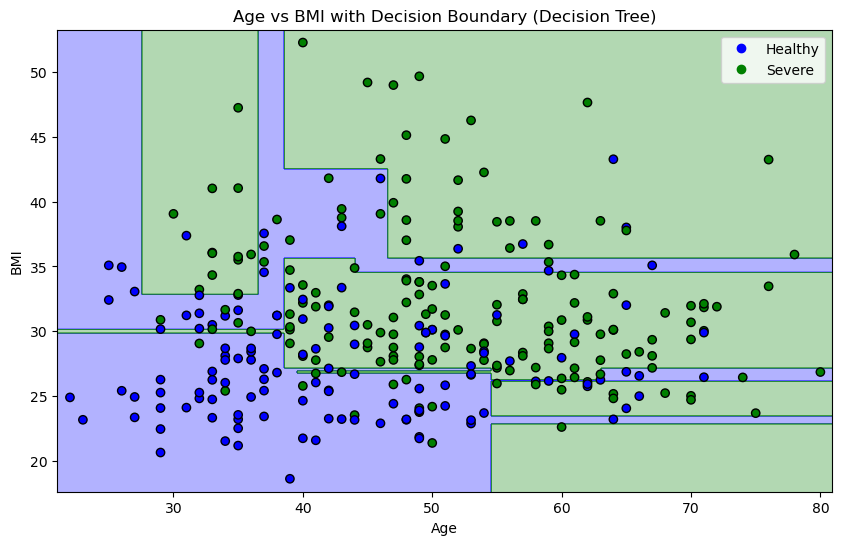

In [61]:
import numpy as np
from matplotlib.colors import ListedColormap

import matplotlib.pyplot as plt

# Define the decision tree model with the specified parameters
decision_tree = DecisionTreeClassifier(max_depth=5, min_samples_leaf=1, min_samples_split=2, random_state=42)

# Train the model
decision_tree.fit(X_train[['Age', 'BMI']], y_train)

# Create a mesh grid for plotting decision boundary
x_min, x_max = X['Age'].min() - 1, X['Age'].max() + 1
y_min, y_max = X['BMI'].min() - 1, X['BMI'].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

# Predict the function value for the whole grid
Z = decision_tree.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot the decision boundary
plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, Z, alpha=0.3, cmap=ListedColormap(['blue', 'green']))

# Plot the points
scatter = plt.scatter(X['Age'], X['BMI'], c=y, edgecolor='k', cmap=ListedColormap(['blue', 'green']))
plt.xlabel('Age')
plt.ylabel('BMI')
plt.title('Age vs BMI with Decision Boundary (Decision Tree)')

# Add legend
handles, labels = scatter.legend_elements()
plt.legend(handles, ['Healthy', 'Severe'], loc='upper right')

plt.show()

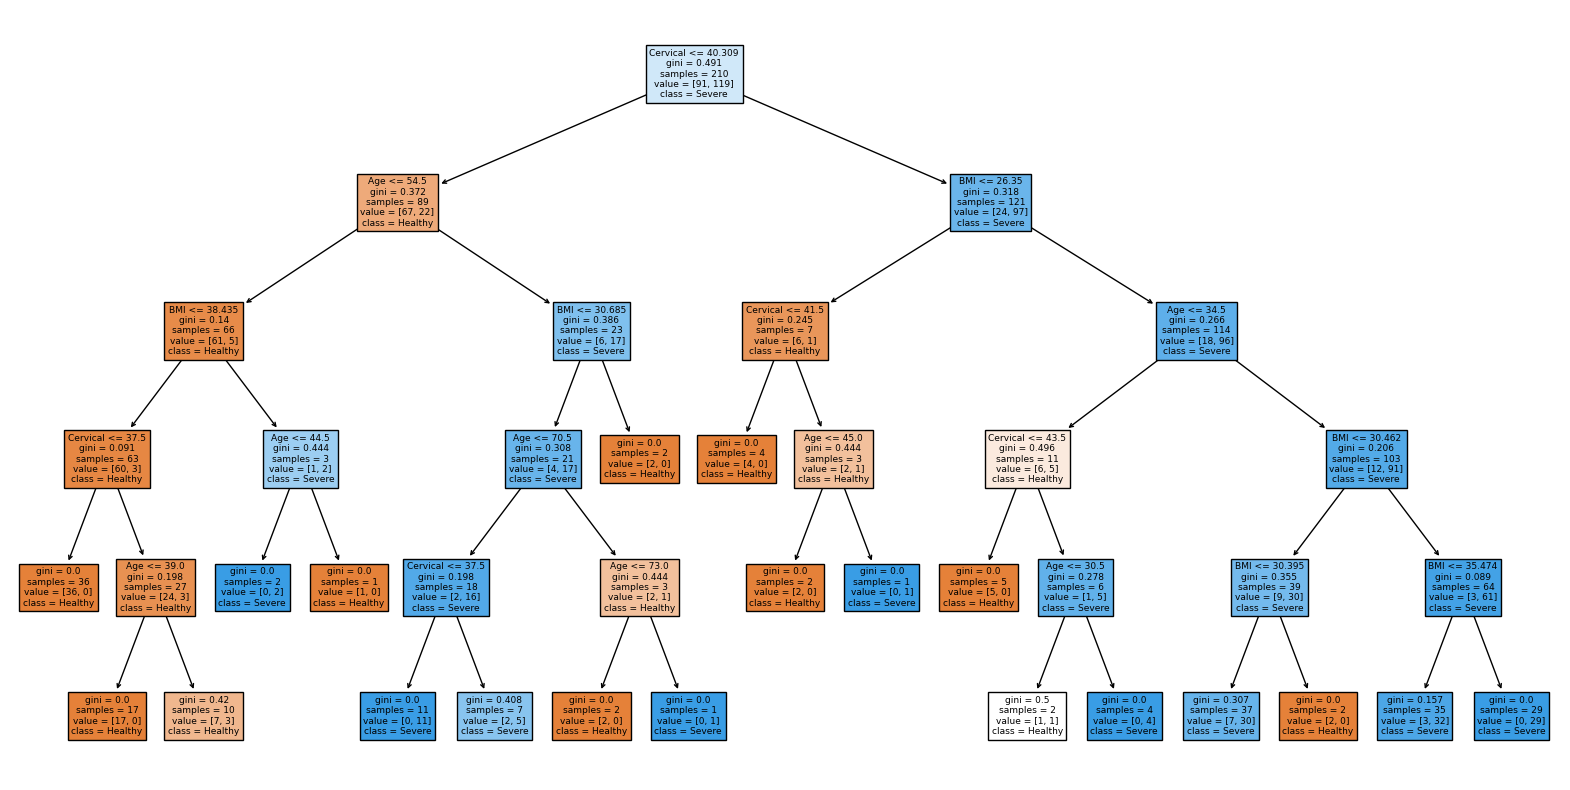

In [21]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

# Train the decision tree with specified parameters
decision_tree = DecisionTreeClassifier(max_depth=5, min_samples_leaf=1, min_samples_split=2, random_state=42)
decision_tree.fit(X_train, y_train)

# Visualize the decision tree
plt.figure(figsize=(20, 10))
plot_tree(decision_tree, feature_names=X.columns, class_names=['Healthy', 'Severe'], filled=True)
plt.show()

## Random Forest 

,accuracy,roc_auc,f1_score,precision,recall,configuration
0,0.733333,0.731429,0.764706,0.787879,0.742857,"{'max_depth': 10, 'max_features': 2, 'min_samp..."
1,0.800000,0.788571,0.833333,0.810811,0.857143,"{'max_depth': None, 'max_features': 4, 'min_sa..."
2,0.783333,0.768100,0.821918,0.769231,0.882353,"{'max_depth': None, 'max_features': 4, 'min_sa..."
3,0.883333,0.880471,0.895522,0.882353,0.909091,"{'max_depth': 10, 'max_features': 2, 'min_samp..."
4,0.833333,0.837054,0.833333,0.892857,0.781250,"{'max_depth': None, 'max_features': 2, 'min_sa..."


-------------------Best parameters based on f1-score-------------------
{'max_depth': 10, 'max_features': 2, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}


,accuracy,roc_auc,f1_score,precision,recall,configuration
0,0.883333,0.880471,0.895522,0.882353,0.909091,"{'max_depth': 10, 'max_features': 2, 'min_samp..."


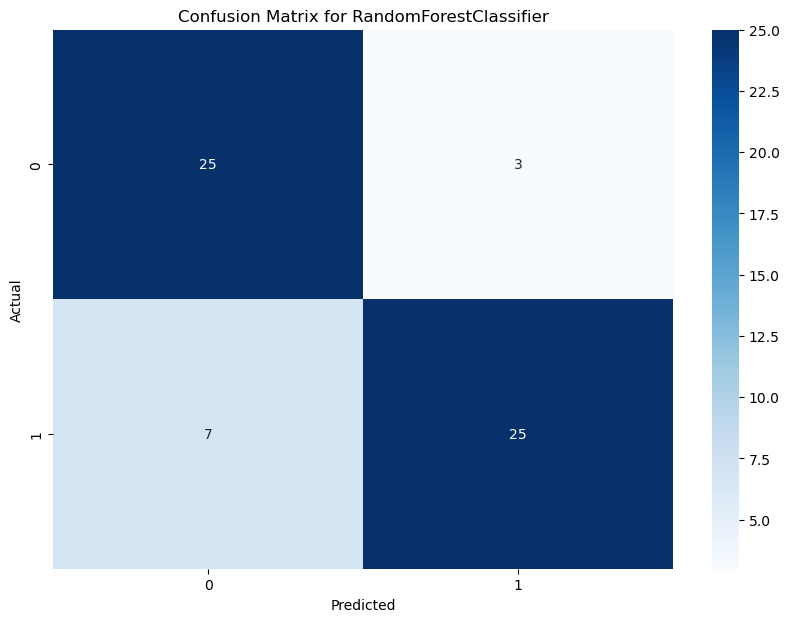

In [22]:
# Define search space for Random Forest
space = dict()
space['n_estimators'] = [10, 50, 100]
space['max_features'] = [2, 4, 6]
space['max_depth'] = [None, 10, 20]
space['min_samples_split'] = [2, 5, 10]
space['min_samples_leaf'] = [1, 2, 4]

# Train Random Forest model using Nested Cross-Validation
Model_Random_Forest = Nested_CV(RandomForestClassifier(random_state=42), space)

c:\Users\pc\anaconda3\envs\ENV_MLLB\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


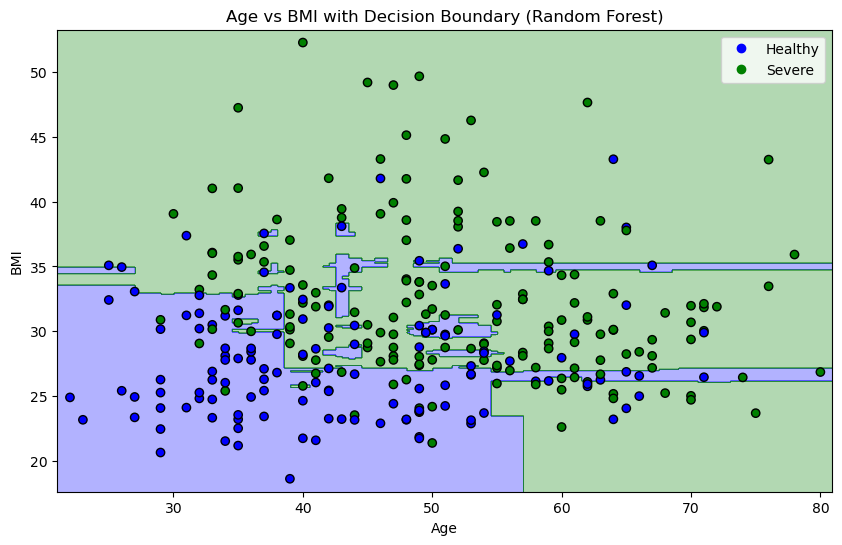

In [54]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from matplotlib.colors import ListedColormap

import matplotlib.pyplot as plt

# Define the Random Forest model with the specified parameters
rf_model = RandomForestClassifier(max_depth=10, max_features=2, min_samples_leaf=1, min_samples_split=5, n_estimators=50, random_state=42)

# Train the model
rf_model.fit(X_train[['Age', 'BMI']], y_train)

# Create a mesh grid for plotting decision boundary
x_min, x_max = X['Age'].min() - 1, X['Age'].max() + 1
y_min, y_max = X['BMI'].min() - 1, X['BMI'].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

# Predict the function value for the whole grid
Z = rf_model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot the decision boundary
plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, Z, alpha=0.3, cmap=ListedColormap(['blue', 'green']))

# Plot the points
scatter = plt.scatter(X['Age'], X['BMI'], c=y, edgecolor='k', cmap=ListedColormap(['blue', 'green']))
plt.xlabel('Age')
plt.ylabel('BMI')
plt.title('Age vs BMI with Decision Boundary (Random Forest)')

# Add legend
handles, labels = scatter.legend_elements()
plt.legend(handles, ['Healthy', 'Severe'], loc='upper right')

plt.show()

Elapsed time to compute the importances: 0.003 seconds


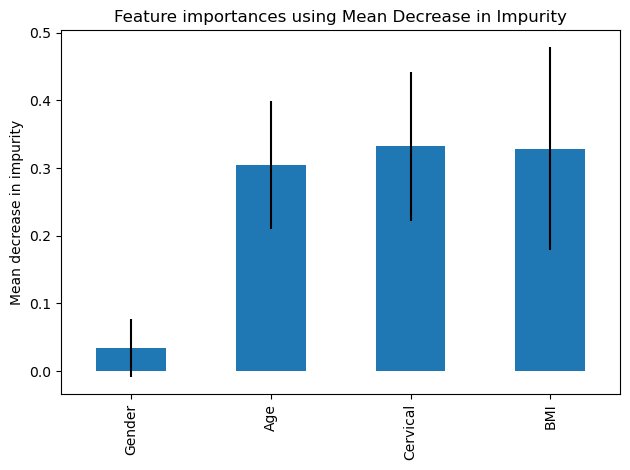

In [23]:
import time
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt

# Assuming X_train and y_train are already defined
forest = RandomForestClassifier(n_estimators=50, max_depth=10, max_features=2, min_samples_leaf=1, min_samples_split=5, random_state=42)
forest.fit(X_train, y_train)

start_time = time.time()
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_importances = pd.Series(importances, index=X_train.columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using Mean Decrease in Impurity")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
plt.show()

Elapsed time to compute the importances: 1.389 seconds


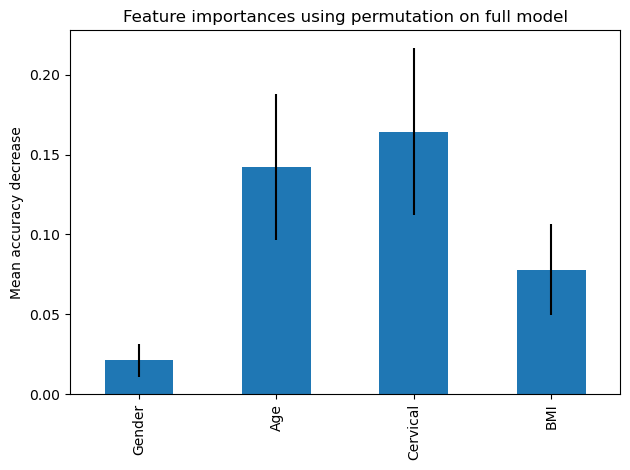

In [25]:
from sklearn.inspection import permutation_importance

columns = X_train.columns

start_time = time.time()
result = permutation_importance(
    forest, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_importances = pd.Series(result.importances_mean, index=columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

## XGBoost 

,accuracy,roc_auc,f1_score,precision,recall,configuration
0,0.766667,0.765714,0.794118,0.818182,0.771429,"{'learning_rate': 0.2, 'max_depth': 5, 'n_esti..."
1,0.800000,0.788571,0.833333,0.810811,0.857143,"{'learning_rate': 0.01, 'max_depth': 5, 'n_est..."
2,0.833333,0.816742,0.864865,0.800000,0.941176,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti..."
3,0.783333,0.776094,0.811594,0.777778,0.848485,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti..."
4,0.783333,0.785714,0.786885,0.827586,0.750000,"{'learning_rate': 0.2, 'max_depth': 7, 'n_esti..."


-------------------Best parameters based on f1-score-------------------
{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 1.0}


,accuracy,roc_auc,f1_score,precision,recall,configuration
0,0.833333,0.816742,0.864865,0.8,0.941176,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti..."


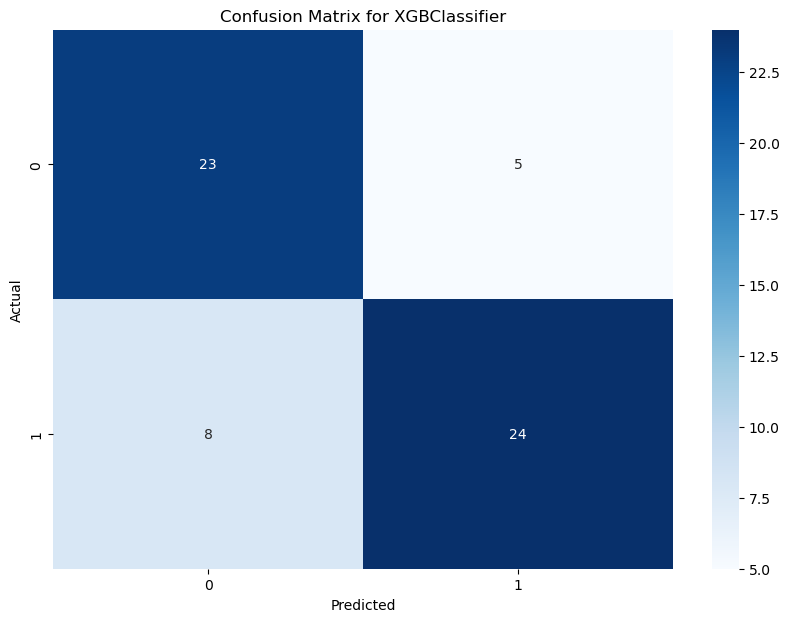

In [26]:
from xgboost import XGBClassifier

# Define search space for XGBoost
space = dict()
space['n_estimators'] = [50, 100, 200]
space['max_depth'] = [3, 5, 7]
space['learning_rate'] = [0.01, 0.1, 0.2]
space['subsample'] = [0.8, 0.9, 1.0]

# Train XGBoost model using Nested Cross-Validation
Model_XGBoost = Nested_CV(XGBClassifier(random_state=42), space)

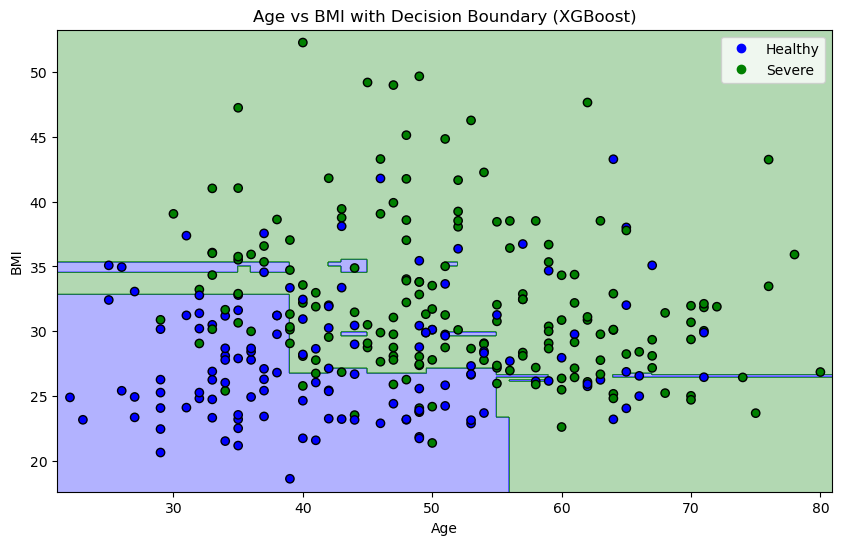

In [55]:
from xgboost import XGBClassifier
import numpy as np
from matplotlib.colors import ListedColormap

import matplotlib.pyplot as plt

# Define the XGBoost model with the specified parameters
xgb_model = XGBClassifier(learning_rate=0.1, max_depth=3, n_estimators=50, subsample=0.8, random_state=42)

# Train the model
xgb_model.fit(X_train[['Age', 'BMI']], y_train)

# Create a mesh grid for plotting decision boundary
x_min, x_max = X['Age'].min() - 1, X['Age'].max() + 1
y_min, y_max = X['BMI'].min() - 1, X['BMI'].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

# Predict the function value for the whole grid
Z = xgb_model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot the decision boundary
plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, Z, alpha=0.3, cmap=ListedColormap(['blue', 'green']))

# Plot the points
scatter = plt.scatter(X['Age'], X['BMI'], c=y, edgecolor='k', cmap=ListedColormap(['blue', 'green']))
plt.xlabel('Age')
plt.ylabel('BMI')
plt.title('Age vs BMI with Decision Boundary (XGBoost)')

# Add legend
handles, labels = scatter.legend_elements()
plt.legend(handles, ['Healthy', 'Severe'], loc='upper right')

plt.show()

## Multilayer Perceptron 

c:\Users\pc\anaconda3\envs\ENV_MLLB\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\pc\anaconda3\envs\ENV_MLLB\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\pc\anaconda3\envs\ENV_MLLB\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\pc\anaconda3\envs\ENV_MLLB\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\pc\anaconda3\envs\E

,accuracy,roc_auc,f1_score,precision,recall,configuration
0,0.716667,0.705714,0.760563,0.750000,0.771429,"{'activation': 'tanh', 'alpha': 0.05, 'hidden_..."
1,0.766667,0.765714,0.794118,0.818182,0.771429,"{'activation': 'relu', 'alpha': 0.0001, 'hidde..."
2,0.766667,0.753394,0.805556,0.763158,0.852941,"{'activation': 'tanh', 'alpha': 0.05, 'hidden_..."
3,0.850000,0.853535,0.857143,0.900000,0.818182,"{'activation': 'tanh', 'alpha': 0.0001, 'hidde..."
4,0.783333,0.785714,0.786885,0.827586,0.750000,"{'activation': 'relu', 'alpha': 0.05, 'hidden_..."


-------------------Best parameters based on f1-score-------------------
{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'max_iter': 500, 'solver': 'adam'}


,accuracy,roc_auc,f1_score,precision,recall,configuration
0,0.85,0.853535,0.857143,0.9,0.818182,"{'activation': 'tanh', 'alpha': 0.0001, 'hidde..."


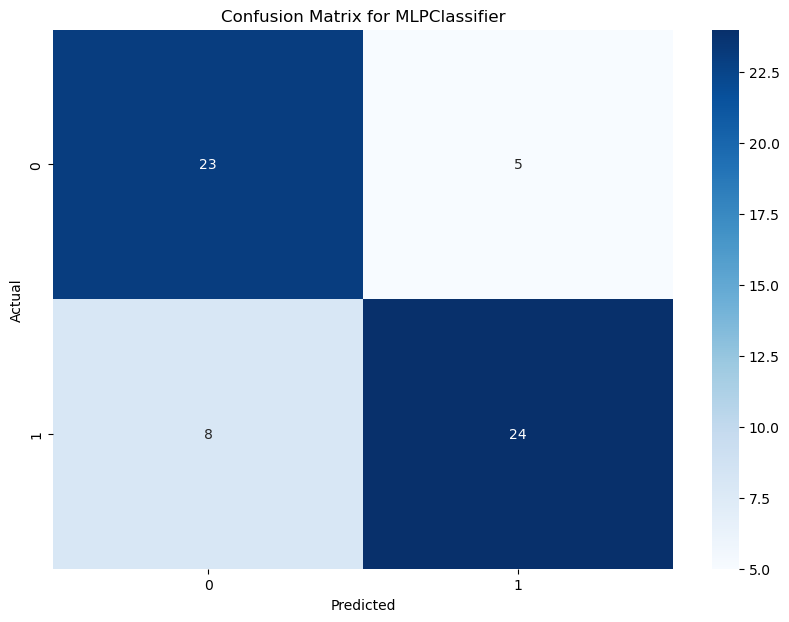

In [102]:
from sklearn.neural_network import MLPClassifier

# Define search space for MLP
space = dict()
space['hidden_layer_sizes'] = [(50,), (100,), (50, 50)]
space['activation'] = ['tanh', 'relu']
space['solver'] = ['sgd', 'adam']
space['alpha'] = [0.0001, 0.05]
space['learning_rate'] = ['constant', 'adaptive']
space['max_iter'] = [500]

# Train MLP model using Nested Cross-Validation
Model_MLP = Nested_CV(MLPClassifier(random_state=42), space)



c:\Users\pc\anaconda3\envs\ENV_MLLB\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


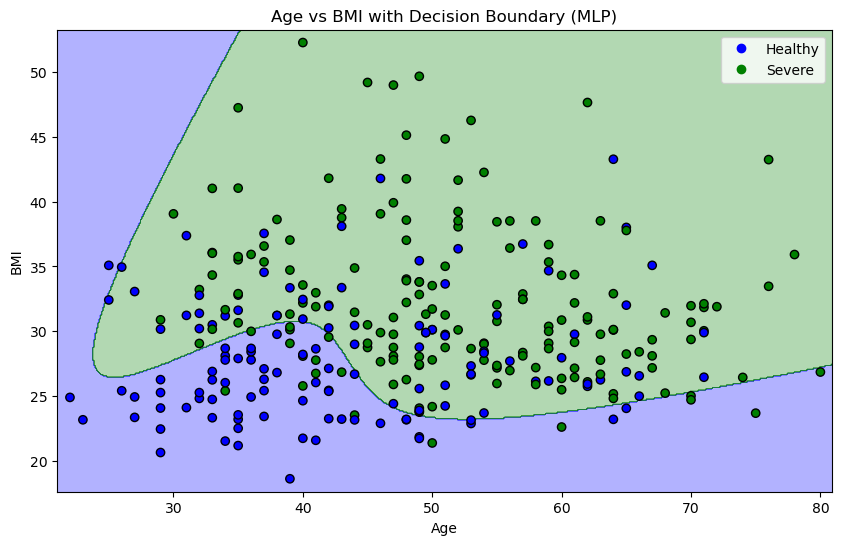

In [105]:
import numpy as np
from matplotlib.colors import ListedColormap
from sklearn.neural_network import MLPClassifier

import matplotlib.pyplot as plt

# Define the MLP model with the specified parameters
mlp_model = MLPClassifier(activation='tanh', alpha=0.0001, hidden_layer_sizes=(100, ), learning_rate='constant', max_iter=500, random_state=42, solver='adam')

# Train the model
mlp_model.fit(X_train[['Age', 'BMI']], y_train)

# Create a mesh grid for plotting decision boundary
x_min, x_max = X['Age'].min() - 1, X['Age'].max() + 1
y_min, y_max = X['BMI'].min() - 1, X['BMI'].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

# Predict the function value for the whole grid
Z = mlp_model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot the decision boundary
plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, Z, alpha=0.3, cmap=ListedColormap(['blue', 'green']))

# Plot the points
scatter = plt.scatter(X['Age'], X['BMI'], c=y, edgecolor='k', cmap=ListedColormap(['blue', 'green']))
plt.xlabel('Age')
plt.ylabel('BMI')
plt.title('Age vs BMI with Decision Boundary (MLP)')

# Add legend
handles, labels = scatter.legend_elements()
plt.legend(handles, ['Healthy', 'Severe'], loc='upper right')

plt.show()

## K-Nearest Neighbor 

,accuracy,roc_auc,f1_score,precision,recall,configuration
0,0.700000,0.685714,0.750000,0.729730,0.771429,"{'metric': 'manhattan', 'n_neighbors': 5, 'wei..."
1,0.766667,0.765714,0.794118,0.818182,0.771429,"{'metric': 'manhattan', 'n_neighbors': 7, 'wei..."
2,0.700000,0.694570,0.735294,0.735294,0.735294,"{'metric': 'euclidean', 'n_neighbors': 5, 'wei..."
3,0.750000,0.749158,0.769231,0.781250,0.757576,"{'metric': 'manhattan', 'n_neighbors': 7, 'wei..."
4,0.833333,0.834821,0.838710,0.866667,0.812500,"{'metric': 'euclidean', 'n_neighbors': 5, 'wei..."


-------------------Best parameters based on f1-score-------------------
{'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'distance'}


,accuracy,roc_auc,f1_score,precision,recall,configuration
0,0.833333,0.834821,0.83871,0.866667,0.8125,"{'metric': 'euclidean', 'n_neighbors': 5, 'wei..."


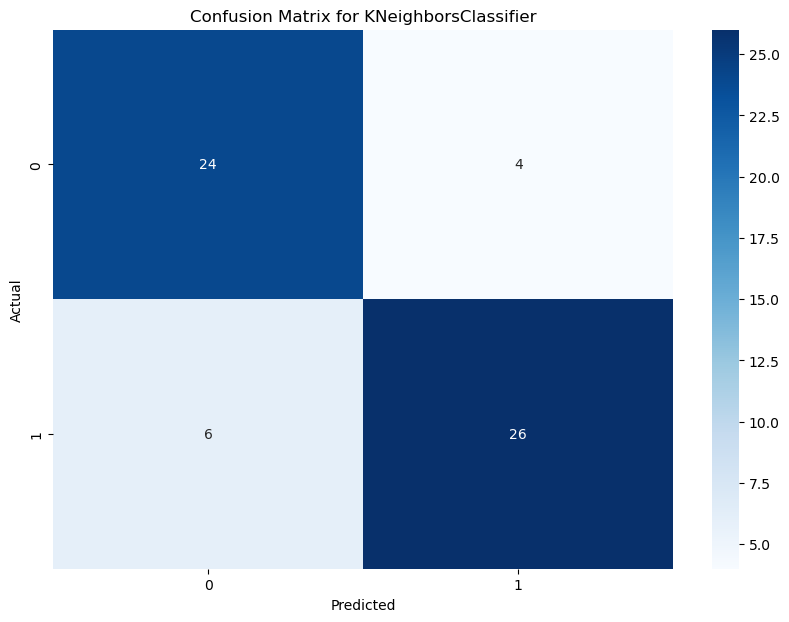

In [28]:
from sklearn.neighbors import KNeighborsClassifier

# Define search space for KNN
space = dict()
space['n_neighbors'] = [3, 5, 7, 9]
space['weights'] = ['uniform', 'distance']
space['metric'] = ['euclidean', 'manhattan']

# Train KNN model using Nested Cross-Validation
Model_KNN = Nested_CV(KNeighborsClassifier(), space)

c:\Users\pc\anaconda3\envs\ENV_MLLB\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


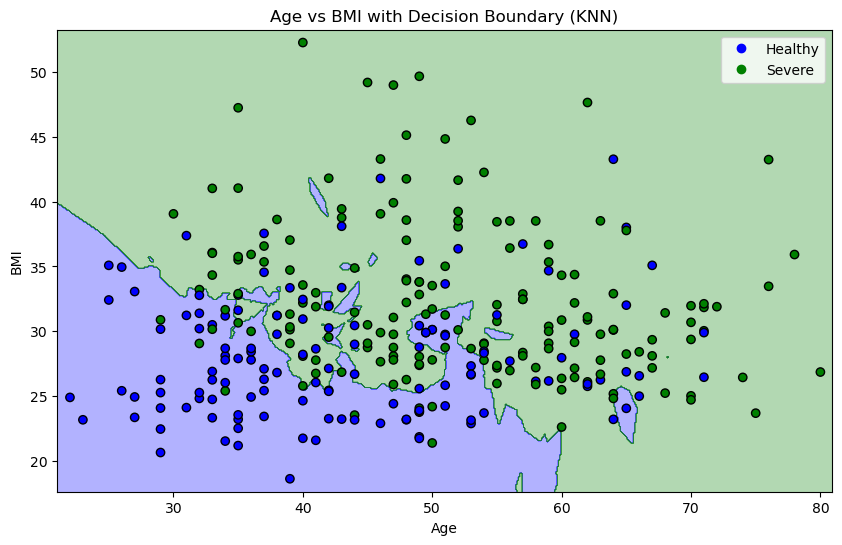

In [60]:
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
from matplotlib.colors import ListedColormap

import matplotlib.pyplot as plt

# Define the KNN model with the specified parameters
knn_model = KNeighborsClassifier(metric='euclidean', n_neighbors=5, weights='uniform')

# Train the model
knn_model.fit(X_train[['Age', 'BMI']], y_train)

# Create a mesh grid for plotting decision boundary
x_min, x_max = X['Age'].min() - 1, X['Age'].max() + 1
y_min, y_max = X['BMI'].min() - 1, X['BMI'].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

# Predict the function value for the whole grid
Z = knn_model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot the decision boundary
plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, Z, alpha=0.3, cmap=ListedColormap(['blue', 'green']))

# Plot the points
scatter = plt.scatter(X['Age'], X['BMI'], c=y, edgecolor='k', cmap=ListedColormap(['blue', 'green']))
plt.xlabel('Age')
plt.ylabel('BMI')
plt.title('Age vs BMI with Decision Boundary (KNN)')

# Add legend
handles, labels = scatter.legend_elements()
plt.legend(handles, ['Healthy', 'Severe'], loc='upper right')

plt.show()